Hyperparameter tuning versus model sizing

batch size

pretrain

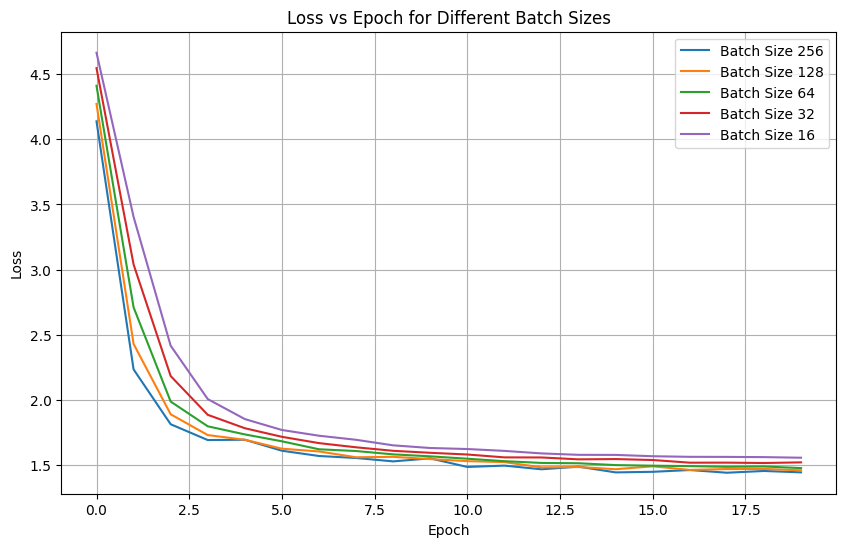

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np

def parse_log_file(file_path):
    epoch_losses = {}
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())  
            epoch = data['epoch']
            loss = data['train_loss']
            lr = data['train_lr']  
            if epoch not in epoch_losses:
                epoch_losses[epoch] = []
            epoch_losses[epoch].append(loss)
    return epoch_losses

batch_sizes = [256,128,64,32,16]
log_files = ['finetune/100%/batch256/log.txt',
            'finetune/100%/batch128/log.txt',
            'finetune/100%/batch64/log.txt',
            'finetune/100%/batch32/log.txt',
            'finetune/100%/batch16/log.txt']
all_losses = {}

for batch_size, log_file in zip(batch_sizes, log_files):
    all_losses[batch_size] = parse_log_file(log_file)


plt.figure(figsize=(10, 6))

for batch_size in batch_sizes:
    epochs = sorted(all_losses[batch_size].keys())
    f_epochs = [e for e in epochs if 0 <= e <= 19] 
    losses = [np.mean(all_losses[batch_size][epoch]) for epoch in f_epochs] 
    plt.plot(f_epochs, losses, label=f'Batch Size {batch_size}')

plt.title('Loss vs Epoch for Different Batch Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

accuracy

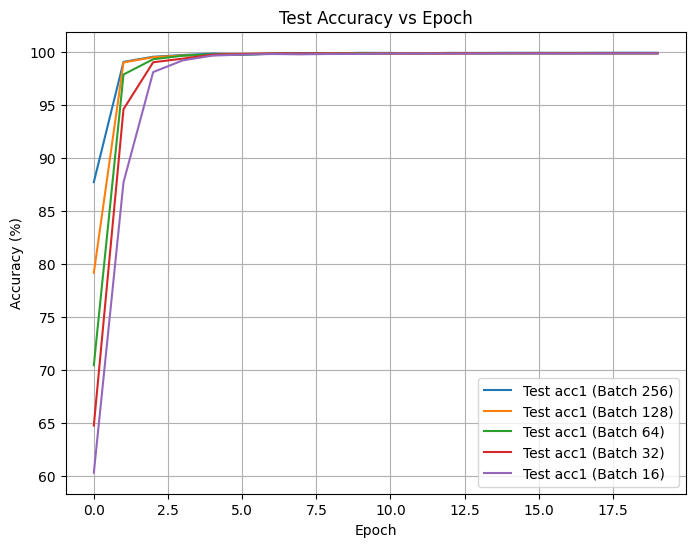

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_log_file(file_path):
    epoch_test_acc1 = {}
    epoch_test_acc5 = {}
    
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())  
            epoch = data['epoch']
            test_acc1 = data['test_acc1']
            test_acc5 = data['test_acc5']
            lr = data['train_lr']  
            
            
            epoch_test_acc1[epoch] = test_acc1
            epoch_test_acc5[epoch] = test_acc5

    return epoch_test_acc1, epoch_test_acc5

batch_sizes = [256,128, 64, 32, 16]
log_files = ['finetune/100%/batch256/log.txt',
    'finetune/100%/batch128/log.txt',
            'finetune/100%/batch64/log.txt',
            'finetune/100%/batch32/log.txt',
            'finetune/100%/batch16/log.txt']
all_test_acc1 = {}
all_test_acc5 = {}

for log_file in log_files:
    test_acc1, test_acc5 = parse_log_file(log_file)
    all_test_acc1[log_file] = test_acc1
    all_test_acc5[log_file] = test_acc5

plt.figure(figsize=(8, 6))

for log_file in log_files:
    matches = re.findall(r"batch(\d+)", log_file)
    
    if matches:
        batch_size = int(matches[-1]) 
        batch_sizes.append(batch_size)
    else:
        batch_sizes.append(None)
    
    f_epochs = sorted(all_test_acc1[log_file].keys())  
    epochs = [e for e in f_epochs if 0 <= e <= 20]  
    test_acc1 = [all_test_acc1[log_file][epoch] for epoch in epochs]
    test_acc5 = [all_test_acc5[log_file][epoch] for epoch in epochs]
    
    plt.plot(epochs, test_acc1, label=f'Test acc1 (Batch {batch_size})')

plt.title('Test Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


time

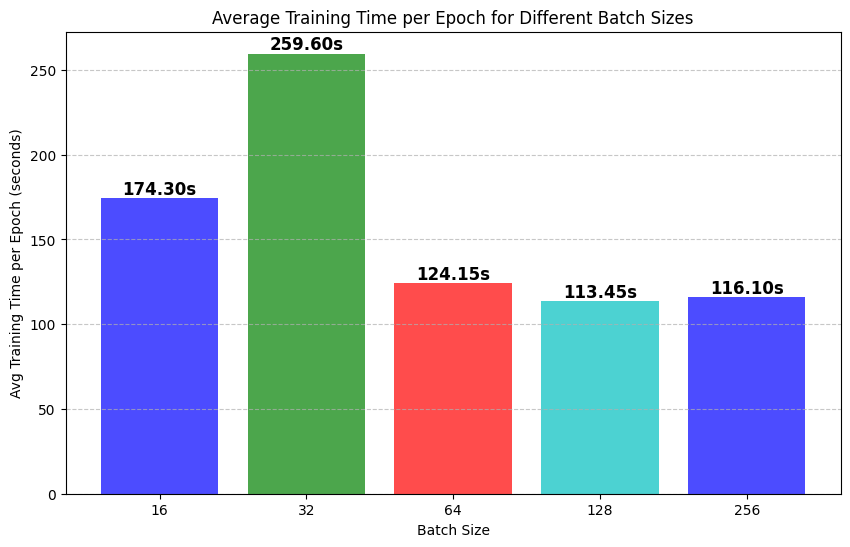

In [4]:
import matplotlib.pyplot as plt
import re
import numpy as np

log_files = {
    16: "finetune/100%/batch16/458_0_log.out",
    32: "finetune/100%/batch32/2785_0_log.out",
    64: "finetune/100%/batch64/3180_0_log.out",
    128: "finetune/100%/batch128/5959_0_log.out",
    256:"finetune/100%/batch256/12895_0_log.out"
}

batch_avg_times = {}

for batch_size, file_path in log_files.items():
    with open(file_path, "r") as f:
        lines = f.readlines()

    epoch_times = [] 
    current_epoch = None

    for line in lines:
        epoch_match = re.search(r"Epoch: \[(\d+)\]", line)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))

        time_match = re.search(r"] Total time: (\d+):(\d+):(\d+) \(([\d\.]+) s / it\)", line)
        if time_match and current_epoch is not None:
            hours = int(time_match.group(1))
            minutes = int(time_match.group(2))
            seconds = int(time_match.group(3))
            total_time = hours * 3600 + minutes * 60 + seconds  
            epoch_times.append(total_time)

    if epoch_times:
        batch_avg_times[batch_size] = np.mean(epoch_times[:20]) 

plt.figure(figsize=(10, 6))
batch_sizes = list(batch_avg_times.keys())
avg_times = list(batch_avg_times.values())

positions = np.arange(len(batch_sizes))

bars = plt.bar(positions, avg_times, color=['b', 'g', 'r', 'c'], alpha=0.7)

for bar, time, batch_size in zip(bars, avg_times, batch_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{time:.2f}s", ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.xlabel("Batch Size")
plt.ylabel("Avg Training Time per Epoch (seconds)")
plt.title("Average Training Time per Epoch for Different Batch Sizes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(positions, batch_sizes)

plt.show()


data agument

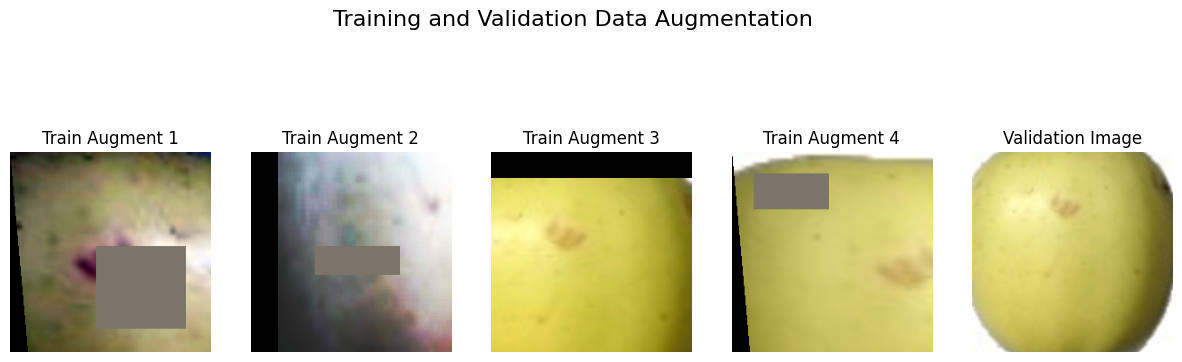

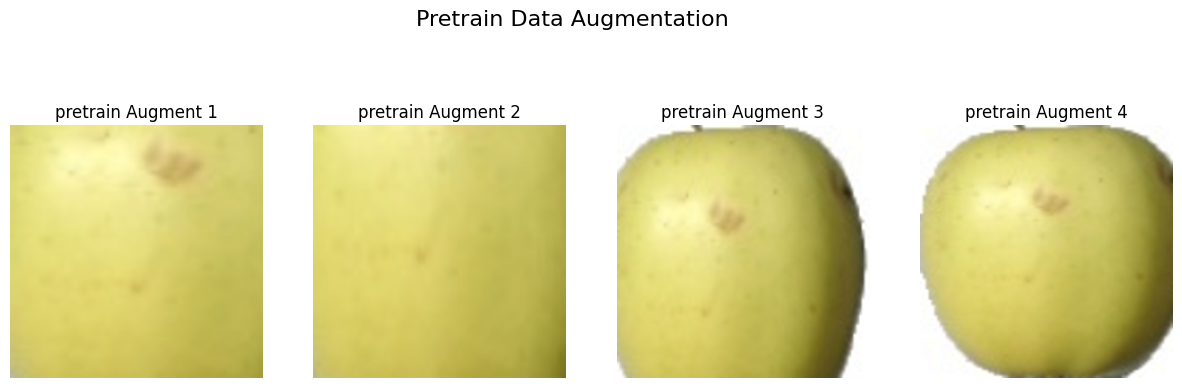

In [27]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from timm.data import RandomResizedCropAndInterpolation
from torchvision.transforms import RandomErasing,RandAugment

image_path = "mae-main/fruit /train-o/Apple Golden 2/105_100.jpg"  
image = Image.open(image_path).convert("RGB")

pretrain_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.2, 1.0), ratio=(0.75, 1.3333), 
                                 interpolation=transforms.InterpolationMode.BICUBIC, antialias=True), 
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.ToTensor(),  
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  
])

train_transform = transforms.Compose([
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation='bicubic'),
    transforms.RandomHorizontalFlip(p=0.5),
    RandAugment(num_ops=2,magnitude=9),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    RandomErasing(p=0.5)  
])


val_transform = transforms.Compose([
    transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC, antialias=True),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


pretrain_images = [pretrain_transform(image).permute(1, 2, 0).numpy() for _ in range(4)]
train_images = [train_transform(image).permute(1, 2, 0).numpy() for _ in range(4)]  
val_image = val_transform(image).permute(1, 2, 0).numpy()  

def denormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 1, 3)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 1, 3)
    return img * std + mean  

pretrain_images = [denormalize(torch.tensor(img)) for img in pretrain_images]
train_images = [denormalize(torch.tensor(img)) for img in train_images]
val_image = denormalize(torch.tensor(val_image))

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(train_images[i])
    axes[i].set_title(f"Train Augment {i+1}")
    axes[i].axis("off")

axes[4].imshow(val_image)
axes[4].set_title("Validation Image")
axes[4].axis("off")

plt.suptitle("Training and Validation Data Augmentation", fontsize=16)
plt.show()
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    axes[i].imshow(pretrain_images[i])
    axes[i].set_title(f"pretrain Augment {i+1}")
    axes[i].axis("off")

plt.suptitle("Pretrain Data Augmentation", fontsize=16)
plt.show()


leaning rate

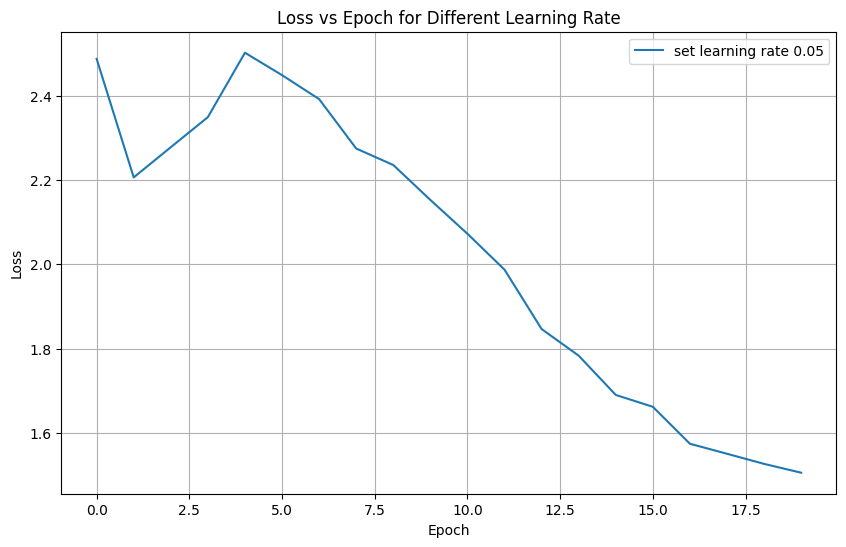

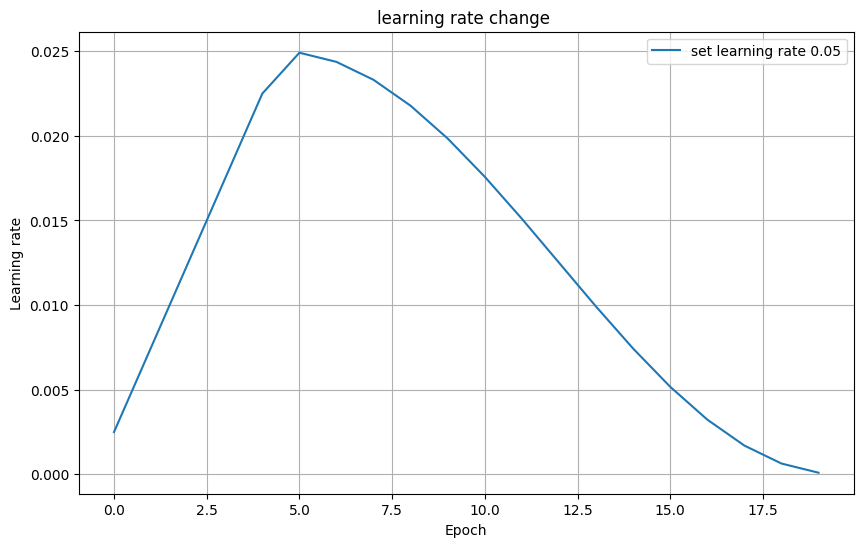

In [5]:
import json
import matplotlib.pyplot as plt
import numpy as np
def parse_log_file(file_path):
    epoch_losses = {}
    epoch_lr={}
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())  
            epoch = data['epoch']
            loss = data['train_loss']
            lr = data['train_lr']  
            if epoch not in epoch_losses:
                epoch_losses[epoch] = []
                epoch_lr[epoch] = []
            epoch_losses[epoch].append(loss)
            epoch_lr[epoch].append(lr)
            
    return epoch_losses,epoch_lr

blrs= [5e-2,5e-3,5e-4,5e-5]
log_files = ['finetune/100%/batch128/lr5e-2/log.txt',
            'finetune/100%/batch128/lr5e-3/log.txt',
            'finetune/100%/batch128/lr5e-4/log.txt',
            'finetune/100%/batch128/lr5e-5/log.txt'
            ]
all_losses = {}
all_lrs={}
for blr, log_file in zip(blrs, log_files):
    all_losses[blr], all_lrs[blr]= parse_log_file(log_file)
    
plt.figure(figsize=(10, 6))

for blr in blrs:
    epochs = sorted(all_losses[blr].keys())
    f_epochs = [e for e in epochs if 0 <= e <= 19] 
    losses = [np.mean(all_losses[blr][epoch]) for epoch in f_epochs] 
    plt.plot(f_epochs, losses, label=f'set learning rate {blr}')

plt.title('Loss vs Epoch for Different Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))

for blr in blrs:
     epochs = sorted(all_lrs[blr].keys())
     f_epochs = [e for e in epochs if 0 <= e <= 19] 
     lrs = [np.mean(all_lrs[blr][epoch]) for epoch in f_epochs] 
     plt.plot(f_epochs, lrs, label=f'set learning rate {blr}')

plt.title('learning rate change ')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.legend()
plt.grid(True)
plt.show()

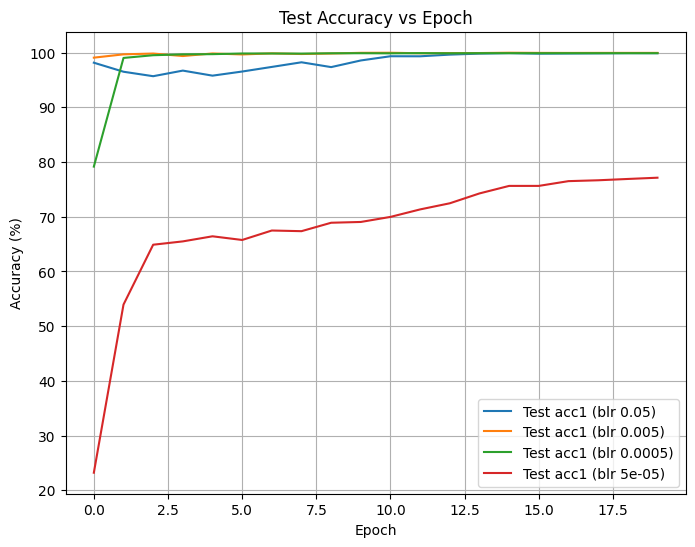

In [8]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_log_file(file_path):
    epoch_test_acc1 = {}
    epoch_test_acc5 = {}
    
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())  
            epoch = data['epoch']
            test_acc1 = data['test_acc1']
            test_acc5 = data['test_acc5']
            lr = data['train_lr'] 
            epoch_test_acc1[epoch] = test_acc1
            epoch_test_acc5[epoch] = test_acc5

    return epoch_test_acc1, epoch_test_acc5

blrs= [5e-2,5e-3,5e-4,5e-5]
log_files = ['finetune/100%/batch128/lr5e-2/log.txt',
            'finetune/100%/batch128/lr5e-3/log.txt',
            'finetune/100%/batch128/lr5e-4/log.txt',
            'finetune/100%/batch128/lr5e-5/log.txt'
            ]
all_test_acc1 = {}
all_test_acc5 = {}


for log_file in log_files:
    test_acc1, test_acc5 = parse_log_file(log_file)
    all_test_acc1[log_file] = test_acc1
    all_test_acc5[log_file] = test_acc5

plt.figure(figsize=(8, 6))

for log_file in log_files:
    matches = re.findall(r"lr([\deE\.-]+)", log_file)  
    if matches:
        try:
            blr = float(matches[0])  
            blrs.append(blr)
        except ValueError:
            blrs.append(None)  
    else:
        blrs.append(None)  
    
    f_epochs = sorted(all_test_acc1[log_file].keys())  
    epochs = [e for e in f_epochs if 0 <= e <= 19]  
    
    
    test_acc1 = [all_test_acc1[log_file][epoch] for epoch in epochs]
    test_acc5 = [all_test_acc5[log_file][epoch] for epoch in epochs]
    
    plt.plot(epochs, test_acc1, label=f'Test acc1 (blr {blr})')

plt.title('Test Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


accuracy

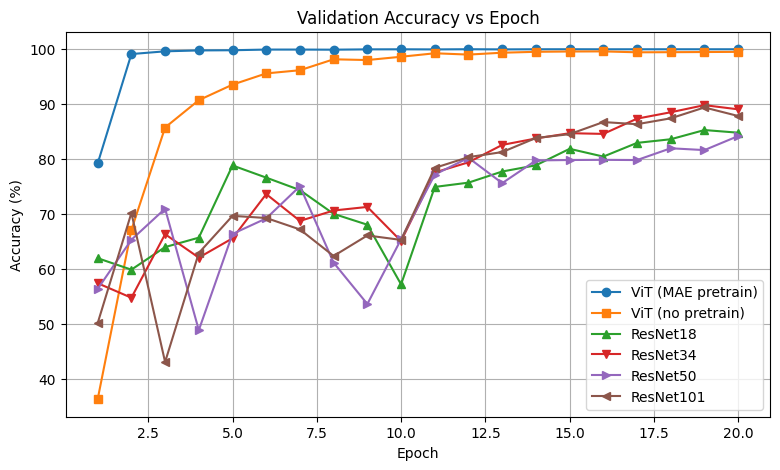

In [18]:
import json
import re
import matplotlib.pyplot as plt

def read_vit_log(file_path):
    
    epochs, val_accs, val_losses = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            try:
                data = json.loads(line.strip())
                epoch = data.get("epoch")+1
                acc = data.get("test_acc1")
                loss = data.get("test_loss")
                if epoch is not None and acc is not None and loss is not None:
                    epochs.append(epoch)
                    val_accs.append(acc)  #
                    val_losses.append(loss)
            except json.JSONDecodeError:
                continue
    return epochs, val_accs, val_losses

def read_resnet_log(file_path):
    
    pattern = re.compile(
        r"Epoch\s+\[(\d+)/\d+\]\s+-\s+Loss:\s+([\d.]+).*?Train Acc:\s+([\d.]+),\s+Val Acc:\s+([\d.]+)"
    )
    epochs, val_accs, losses = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                epoch = int(match.group(1))
                # train_loss = float(match.group(2))  
                # train_acc = float(match.group(3))
                val_acc = float(match.group(4)) * 100 
                loss = float(match.group(3))
                
                epochs.append(epoch)
                val_accs.append(val_acc)
                losses.append(loss)
    return epochs, val_accs, losses


vit_mae_file = "finetune/100%/batch128/lr5e-4/log.txt"
vit_no_pretrain_file = "finetune/100%/batch128/lr5e-4/no/log.txt"
resnet18_file = "resnet/log18.txt"
resnet34_file = "resnet/log34.txt"
resnet50_file = "resnet/log50.txt"
resnet101_file = "resnet/log101.txt"


vit_mae_epochs, vit_mae_acc, vit_mae_loss = read_vit_log(vit_mae_file)
vit_no_epochs, vit_no_acc, vit_no_loss = read_vit_log(vit_no_pretrain_file)

r18_epochs, r18_acc, r18_loss = read_resnet_log(resnet18_file)
r34_epochs, r34_acc, r34_loss = read_resnet_log(resnet34_file)
r50_epochs, r50_acc, r50_loss = read_resnet_log(resnet50_file)
r101_epochs, r101_acc, r101_loss = read_resnet_log(resnet101_file)


plt.figure(figsize=(20, 5))
plt.plot(vit_mae_epochs, vit_mae_acc, label="ViT (MAE pretrain)", marker='o')
plt.plot(vit_no_epochs, vit_no_acc, label="ViT (no pretrain)", marker='s')

plt.plot(r18_epochs, r18_acc, label="ResNet18", marker='^')
plt.plot(r34_epochs, r34_acc, label="ResNet34", marker='v')
plt.plot(r50_epochs, r50_acc, label="ResNet50", marker='>')
plt.plot(r101_epochs, r101_acc, label="ResNet101", marker='<')

plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)



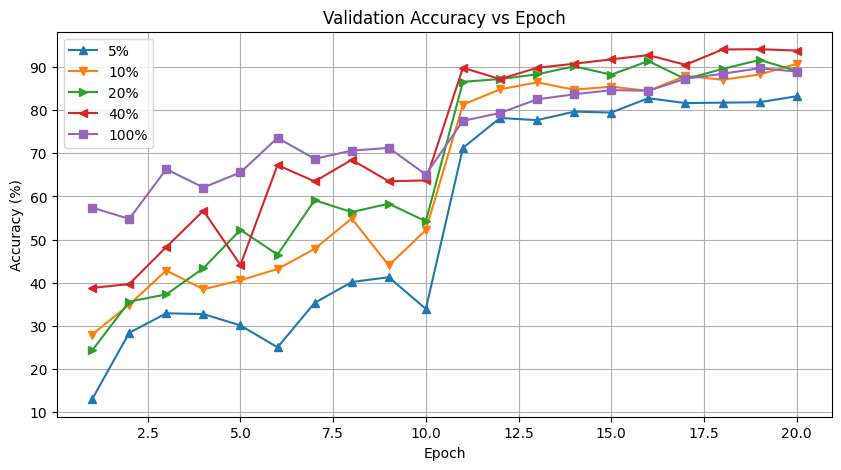

In [3]:
import json
import re
import matplotlib.pyplot as plt

# def read_vit_log(file_path):
#     
#     epochs, val_accs, val_losses = [], [], []
#     with open(file_path, 'r') as f:
#         for line in f:
#             try:
#                 data = json.loads(line.strip())
#                 epoch = data.get("epoch")+1
#                 acc = data.get("test_acc1")
#                 loss = data.get("test_loss")
#                 if epoch is not None and acc is not None and loss is not None:
#                     epochs.append(epoch)
#                     val_accs.append(acc)  
#                     val_losses.append(loss)
#             except json.JSONDecodeError:
#                 continue
#     return epochs, val_accs, val_losses

def read_resnet_log(file_path):
    
    pattern = re.compile(
        r"Epoch\s+\[(\d+)/\d+\]\s+-\s+Loss:\s+([\d.]+).*?Train Acc:\s+([\d.]+),\s+Val Acc:\s+([\d.]+)"
    )
    epochs, val_accs, losses = [], [], []
    with open(file_path, 'r') as f:
        for line in f:
            match = pattern.search(line)
            if match:
                epoch = int(match.group(1))
                # train_loss = float(match.group(2))  
                # train_acc = float(match.group(3))
                val_acc = float(match.group(4)) * 100  
                loss = float(match.group(3))
                
                epochs.append(epoch)
                val_accs.append(val_acc)
                losses.append(loss)
    return epochs, val_accs, losses


# vit_mae_file = "finetune/100%/batch128/lr5e-4/log.txt"
# vit_no_pretrain_file = "finetune/100%/batch128/lr5e-4/no/log.txt"
resnet5_file = "resnet/log34-5.txt"
resnet10_file = "resnet/log34-10.txt"
resnet20_file = "resnet/log34-20.txt"
resnet40_file = "resnet/log34-40.txt"
resnet100_file = "resnet/log34.txt"



# vit_mae_epochs, vit_mae_acc, vit_mae_loss = read_vit_log(vit_mae_file)
# vit_no_epochs, vit_no_acc, vit_no_loss = read_vit_log(vit_no_pretrain_file)

r5_epochs, r5_acc, r5_loss = read_resnet_log(resnet5_file)
r10_epochs, r10_acc, r10_loss = read_resnet_log(resnet10_file)
r20_epochs, r20_acc, r20_loss = read_resnet_log(resnet20_file)
r40_epochs, r40_acc, r40_loss = read_resnet_log(resnet40_file)
r100_epochs, r100_acc, r100_loss = read_resnet_log(resnet100_file)


plt.figure(figsize=(10, 5))
# plt.plot(vit_mae_epochs, vit_mae_acc, label="ViT (MAE pretrain)", marker='o')
# plt.plot(vit_no_epochs, vit_no_acc, label="ViT (no pretrain)", marker='s')

plt.plot(r5_epochs, r5_acc, label="5%", marker='^')
plt.plot(r10_epochs, r10_acc, label="10%", marker='v')
plt.plot(r20_epochs, r20_acc, label="20%", marker='>')
plt.plot(r40_epochs, r40_acc, label="40%", marker='<')
plt.plot(r100_epochs, r100_acc, label="100%", marker='s')
plt.title("Validation Accuracy vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()
plt.grid(True)



dataset size

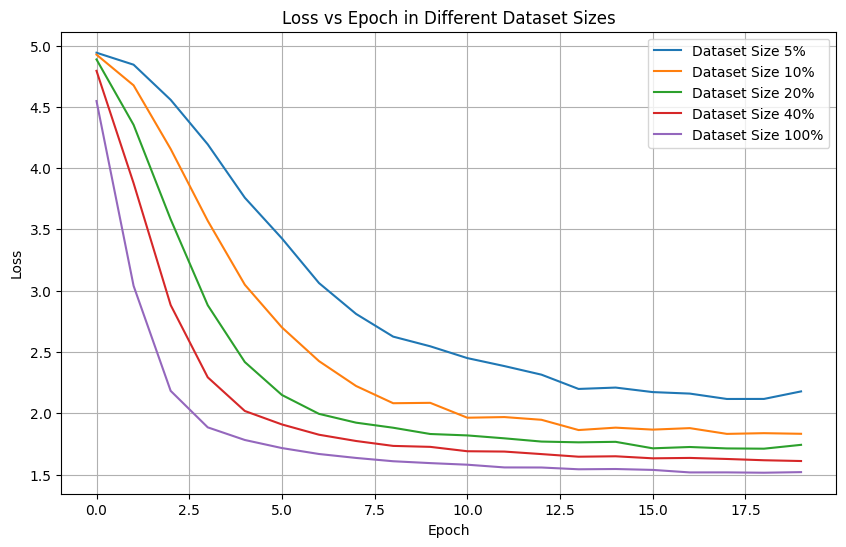

In [9]:
import json
import matplotlib.pyplot as plt
import numpy as np
def parse_log_file(file_path):
    epoch_losses = {}
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip()) 
            epoch = data['epoch']
            loss = data['train_loss']
            lr = data['train_lr'] 
            if epoch not in epoch_losses:
                epoch_losses[epoch] = []
            epoch_losses[epoch].append(loss)
    return epoch_losses


sizes = [5,10,20,40,100]
log_files = ['finetune/5%/log.txt',
            'finetune/10%/log.txt',
            'finetune/20%/log.txt',
            'finetune/40%/batch 32/log.txt',
            'finetune/100%/batch32/log.txt']
all_losses = {}

for size, log_file in zip(sizes, log_files):
    all_losses[size] = parse_log_file(log_file)


plt.figure(figsize=(10, 6))

for size in sizes:
    epochs = sorted(all_losses[size].keys())
    f_epochs = [e for e in epochs if 0 <= e <= 19] 
    losses = [np.mean(all_losses[size][epoch]) for epoch in f_epochs] 
    plt.plot(f_epochs, losses, label=f'Dataset Size {size}%')

plt.title('Loss vs Epoch in Different Dataset Sizes')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

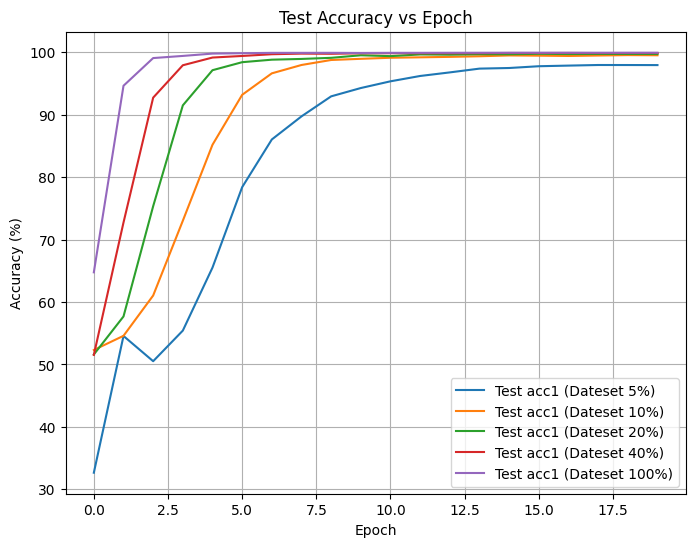

In [11]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re

def parse_log_file(file_path):
    epoch_test_acc1 = {}
    epoch_test_acc5 = {}
    
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip())  
            epoch = data['epoch']
            test_acc1 = data['test_acc1']
            test_acc5 = data['test_acc5']
            lr = data['train_lr']  
            
            epoch_test_acc1[epoch] = test_acc1
            epoch_test_acc5[epoch] = test_acc5

    return epoch_test_acc1, epoch_test_acc5

d_sizes = [5,10,20,40,100]
log_files = ['finetune/5%/log.txt',
            'finetune/10%/log.txt',
            'finetune/20%/log.txt',
            'finetune/40%/batch 32/log.txt',
            'finetune/100%/batch32/log.txt']
all_test_acc1 = {}
all_test_acc5 = {}

for log_file in log_files:
    test_acc1, test_acc5 = parse_log_file(log_file)
    all_test_acc1[log_file] = test_acc1
    all_test_acc5[log_file] = test_acc5

plt.figure(figsize=(8, 6))


for log_file in log_files:
   
    matches = re.findall(r"(\d+)%", log_file)
    if matches:
        d_size = int(matches[0])  
        d_sizes.append(d_size)
    f_epochs = sorted(all_test_acc1[log_file].keys())  
    epochs = [e for e in f_epochs if 0 <= e <= 20]  
    
    test_acc1 = [all_test_acc1[log_file][epoch] for epoch in epochs]
    test_acc5 = [all_test_acc5[log_file][epoch] for epoch in epochs]
    
    plt.plot(epochs, test_acc1, label=f'Test acc1 (Dateset {d_size}%)')

plt.title('Test Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import re
import numpy as np

log_files = {
    16: "finetune/100%/batch128/lr5e-4/no/17141_0_log.out",
    32: "finetune/100%/batch128/5959_0_log.out",
    
}


batch_avg_times = {}


for batch_size, file_path in log_files.items():
    with open(file_path, "r") as f:
        lines = f.readlines()

    epoch_times = []  
    current_epoch = None

    for line in lines:
        
        epoch_match = re.search(r"Epoch: \[(\d+)\]", line)
        if epoch_match:
            current_epoch = int(epoch_match.group(1))

        time_match = re.search(r"] Total time: (\d+):(\d+):(\d+) \(([\d\.]+) s / it\)", line)
        if time_match and current_epoch is not None:
            hours = int(time_match.group(1))
            minutes = int(time_match.group(2))
            seconds = int(time_match.group(3))
            total_time = hours * 3600 + minutes * 60 + seconds 
            epoch_times.append(total_time)

    if epoch_times:
        batch_avg_times[batch_size] = np.mean(epoch_times[:20]) 

plt.figure(figsize=(10, 6))
batch_sizes = list(batch_avg_times.keys())
avg_times = list(batch_avg_times.values())

positions = np.arange(len(batch_sizes))

bars = plt.bar(positions, avg_times, color=['b', 'g', 'r', 'c'], alpha=0.7)

for bar, time, batch_size in zip(bars, avg_times, batch_sizes):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{time:.2f}s", ha='center', va='bottom', fontsize=12, fontweight='bold')


plt.xlabel("Batch Size")
plt.ylabel("Avg Training Time per Epoch (seconds)")
plt.title("Average Training Time per Epoch for Different Batch Sizes")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(positions, batch_sizes)

plt.show()


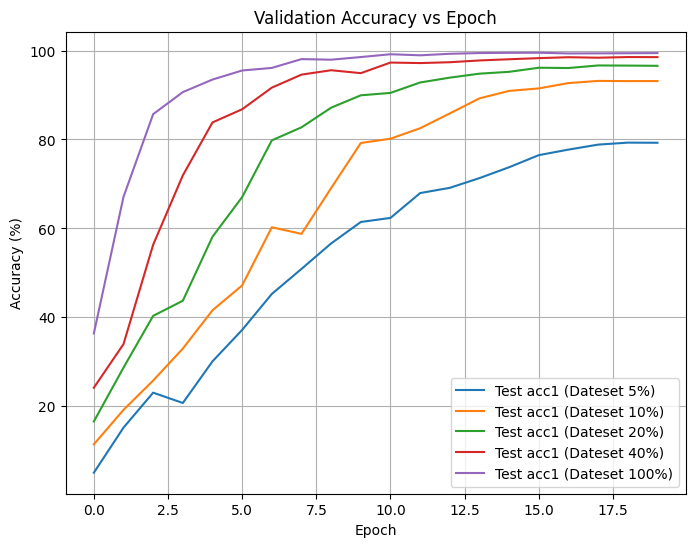

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
def parse_log_file(file_path):
    epoch_test_acc1 = {}
    epoch_test_acc5 = {}
    
    with open(file_path, 'r') as f:
        for line in f:
            data = json.loads(line.strip()) 
            epoch = data['epoch']
            test_acc1 = data['test_acc1']
            test_acc5 = data['test_acc5']
            lr = data['train_lr'] 
           
            epoch_test_acc1[epoch] = test_acc1
            epoch_test_acc5[epoch] = test_acc5

    return epoch_test_acc1, epoch_test_acc5

d_sizes = [5,10,20,40,100]
log_files = ['finetune/5%/no/log.txt',
            'finetune/10%/no /log.txt',
            'finetune/20%/no/log.txt',
            'finetune/40%/batch128/no/log.txt',
            'finetune/100%/batch128/lr5e-4/no/log.txt']
all_test_acc1 = {}
all_test_acc5 = {}


for log_file in log_files:
    test_acc1, test_acc5 = parse_log_file(log_file)
    all_test_acc1[log_file] = test_acc1
    all_test_acc5[log_file] = test_acc5


plt.figure(figsize=(8, 6))


for log_file in log_files:
   
    matches = re.findall(r"(\d+)%", log_file)
    if matches:
        d_size = int(matches[0])  
        d_sizes.append(d_size)
    f_epochs = sorted(all_test_acc1[log_file].keys()) 
    epochs = [e for e in f_epochs if 0 <= e <= 20]  
    
    
    test_acc1 = [all_test_acc1[log_file][epoch] for epoch in epochs]
    test_acc5 = [all_test_acc5[log_file][epoch] for epoch in epochs]
    
    
    plt.plot(epochs, test_acc1, label=f'Test acc1 (Dateset {d_size}%)')


plt.title('Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
